# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.06.15

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_5\20220419-P_brain_CTP11-13_from_0415storm65'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65'

save_folder = r'\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65'

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

20496


## 0.1 Folders

In [3]:
save_folder = r'\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

picked_folder = os.path.join(save_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

217 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder
Creating picked_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Picked_v0


In [4]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [5]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
ctp13_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9600471-9656458,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:9749317-9845402,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,1:20888605-20953251,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
3,1:21475446-21564433,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,1:21674557-21793163,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,X:101910335-102015609,987,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,X,2
964,X:136772307-136851006,988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,3
965,X:140481839-140547985,989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,4
966,X:167122110-167191320,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,5


## Load bit_2_name

In [6]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

,Bit,ReadoutName
0,1,NDB_784
1,2,NDB_755
2,3,NDB_826
3,4,NDB_713
4,5,NDB_865
...,...,...
90,191,NDB_592
91,192,NDB_368
92,193,NDB_436
93,194,NDB_629


## 3.3 prepare kwargs to decode CTP11

In [7]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp11_data_type = 'combo'
ctp11_lib_name = 'CTP11'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp11_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            (ctp11_lib_name, _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0, 101
- Preparing decoding args for fov: 1, 248
- Preparing decoding args for fov: 2, 389
- Preparing decoding args for fov: 3, 525
- Preparing decoding args for fov: 4, 668
- Preparing decoding args for fov: 5, 793
- Preparing decoding args for fov: 6, 946
- Preparing decoding args for fov: 7, 1087
- Preparing decoding args for fov: 8, 1218
- Preparing decoding args for fov: 9, 1329
- Preparing decoding args for fov: 10, 1446
- Preparing decoding args for fov: 11, 1570
- Preparing decoding args for fov: 12, 1687
- Preparing decoding args for fov: 13, 1807
- Preparing decoding args for fov: 14, 1925
- Preparing decoding args for fov: 15, 2043
- Preparing decoding args for fov: 16, 2171
- Preparing decoding args for fov: 17, 2311
- Preparing decoding args for fov: 18, 2412
- Preparing decoding args for fov: 19, 2522
- Preparing decoding args for fov: 20, 2634
- Preparing decoding args for fov: 21, 2744
- Preparing decoding args for fov: 22, 2861
- Pre

- Preparing decoding args for fov: 182, 20172
- Preparing decoding args for fov: 183, 20306
- Preparing decoding args for fov: 184, 20424
- Preparing decoding args for fov: 185, 20534
- Preparing decoding args for fov: 186, 20665
- Preparing decoding args for fov: 187, 20809
- Preparing decoding args for fov: 188, 20925
- Preparing decoding args for fov: 189, 21036
- Preparing decoding args for fov: 190, 21148
- Preparing decoding args for fov: 191, 21259
- Preparing decoding args for fov: 192, 21405
- Preparing decoding args for fov: 193, 21534
- Preparing decoding args for fov: 194, 21658
- Preparing decoding args for fov: 195, 21756
- Preparing decoding args for fov: 196, 21856
- Preparing decoding args for fov: 197, 21977
- Preparing decoding args for fov: 198, 22093
- Preparing decoding args for fov: 199, 22191
- Preparing decoding args for fov: 200, 22315
- Preparing decoding args for fov: 201, 22458
- Preparing decoding args for fov: 202, 22609
- Preparing decoding args for fov:

## Test decoding for one cell

In [8]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 10

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
#batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- savefile:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5 not exist, skip
- Matching 194 bits to (988, 103) codebook


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 27247 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████| 27247/27247 [00:06<00:00, 4516.69it/s]


-- 2668 full tuples selected


100%|████████████████████████████████████████████████████████████████████████| 27247/27247 [00:00<00:00, 122426.90it/s]


-- 2687 pairs selected
-- in total 5355 spot_groups detected
- Save decoder of CTP11 into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  pytables.to_hdf(


- Save spot_stats iamage to file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11_CTP11_stats.png


## Plot decoded spots

In [9]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [10]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


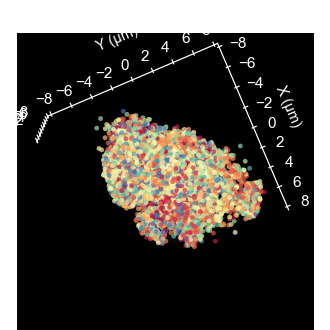

In [13]:
%matplotlib notebook
sel_lib = 'CTP11'
_decoded_groups = pd.read_hdf(ctp11_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

# Process All

In [15]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp11_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

24481
Wall time: 2h 6min 15s


## 3.4 prepare kwargs to decode CTP13

In [16]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0, 101
- Preparing decoding args for fov: 1, 248
- Preparing decoding args for fov: 2, 389
- Preparing decoding args for fov: 3, 525
- Preparing decoding args for fov: 4, 668
- Preparing decoding args for fov: 5, 793
- Preparing decoding args for fov: 6, 946
- Preparing decoding args for fov: 7, 1087
- Preparing decoding args for fov: 8, 1218
- Preparing decoding args for fov: 9, 1329
- Preparing decoding args for fov: 10, 1446
- Preparing decoding args for fov: 11, 1570
- Preparing decoding args for fov: 12, 1687
- Preparing decoding args for fov: 13, 1807
- Preparing decoding args for fov: 14, 1925
- Preparing decoding args for fov: 15, 2043
- Preparing decoding args for fov: 16, 2171
- Preparing decoding args for fov: 17, 2311
- Preparing decoding args for fov: 18, 2412
- Preparing decoding args for fov: 19, 2522
- Preparing decoding args for fov: 20, 2634
- Preparing decoding args for fov: 21, 2744
- Preparing decoding args for fov: 22, 2861
- Pre

- Preparing decoding args for fov: 182, 20172
- Preparing decoding args for fov: 183, 20306
- Preparing decoding args for fov: 184, 20424
- Preparing decoding args for fov: 185, 20534
- Preparing decoding args for fov: 186, 20665
- Preparing decoding args for fov: 187, 20809
- Preparing decoding args for fov: 188, 20925
- Preparing decoding args for fov: 189, 21036
- Preparing decoding args for fov: 190, 21148
- Preparing decoding args for fov: 191, 21259
- Preparing decoding args for fov: 192, 21405
- Preparing decoding args for fov: 193, 21534
- Preparing decoding args for fov: 194, 21658
- Preparing decoding args for fov: 195, 21756
- Preparing decoding args for fov: 196, 21856
- Preparing decoding args for fov: 197, 21977
- Preparing decoding args for fov: 198, 22093
- Preparing decoding args for fov: 199, 22191
- Preparing decoding args for fov: 200, 22315
- Preparing decoding args for fov: 201, 22458
- Preparing decoding args for fov: 202, 22609
- Preparing decoding args for fov:

## Test decoding the same cell

In [17]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder

# conbinatorial
#batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- savefile:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5 doesn't have information for CTP13, skip
- Matching 194 bits to (968, 99) codebook
-- 95 bits matched
- Process (968, 98) codebook into valid pairs
-- 2904 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 27027 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████| 27027/27027 [00:06<00:00, 4154.53it/s]


-- 2522 full tuples selected


100%|████████████████████████████████████████████████████████████████████████| 27027/27027 [00:00<00:00, 128491.22it/s]


-- 2703 pairs selected
-- in total 5225 spot_groups detected
- Save decoder of CTP13 into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  pytables.to_hdf(


- Save spot_stats iamage to file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11_CTP13_stats.png


<IPython.core.display.Javascript object>


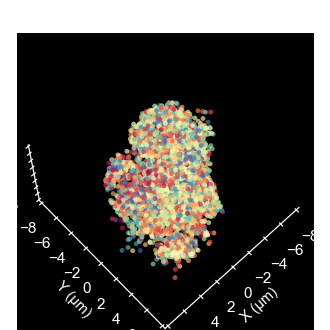

In [18]:
%matplotlib notebook
sel_lib = 'CTP13'
_decoded_groups = pd.read_hdf(ctp13_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp13_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

## Process ALL

In [19]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp13_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

24481
Wall time: 2h 11min 42s


# 5. CTP12, sequential TSS for markergenes

## 5.1 prepare kwargs to map sequential CTP12

In [20]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

,name,id,chr,Stv_91,Stv_32,Stv_92,Stv_33,Stv_94,Stv_35,Stv_95,...,Stv_106,Stv_45,Stv_107,Stv_46,Stv_109,Stv_48,Stv_118,Stv_50,Stv_119,Stv_53
0,5:31098237-31118237,Slc30a3,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7:45153949-45173949,Slc17a7,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2:158600767-158620767,Slc32a1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2:70543072-70563072,Gad1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5:30451932-30471932,Otof,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4:124976430-124996430,Rspo1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,15:78196400-78216400,Pvalb,15,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,16:23880958-23900958,Sst,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10:5629218-5649218,Vip,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14:34364789-34384789,Sncg,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

,Bit,ReadoutName
0,1,Stv_91
1,2,Stv_32
2,3,Stv_92
3,4,Stv_33
4,5,Stv_94
5,6,Stv_35
6,7,Stv_95
7,8,Stv_36
8,9,Stv_99
9,10,Stv_37


In [ ]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

In [24]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

ctp12_lib_name = 'CTP12tss'
ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp12_lib_name in _f.keys():
                    continue

        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp12_decode_args.append(
            (ctp12_lib_name, _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp12_decode_args))

- Preparing decoding args for fov: 0, 100
- Preparing decoding args for fov: 1, 242
- Preparing decoding args for fov: 2, 379
- Preparing decoding args for fov: 3, 513
- Preparing decoding args for fov: 4, 653
- Preparing decoding args for fov: 5, 774
- Preparing decoding args for fov: 6, 923
- Preparing decoding args for fov: 7, 1062
- Preparing decoding args for fov: 8, 1193
- Preparing decoding args for fov: 9, 1301
- Preparing decoding args for fov: 10, 1415
- Preparing decoding args for fov: 11, 1539
- Preparing decoding args for fov: 12, 1649
- Preparing decoding args for fov: 13, 1767
- Preparing decoding args for fov: 14, 1882
- Preparing decoding args for fov: 15, 1998
- Preparing decoding args for fov: 16, 2117
- Preparing decoding args for fov: 17, 2251
- Preparing decoding args for fov: 18, 2350
- Preparing decoding args for fov: 19, 2459
- Preparing decoding args for fov: 20, 2567
- Preparing decoding args for fov: 21, 2674
- Preparing decoding args for fov: 22, 2785
- Pre

- Preparing decoding args for fov: 182, 19398
- Preparing decoding args for fov: 183, 19531
- Preparing decoding args for fov: 184, 19647
- Preparing decoding args for fov: 185, 19754
- Preparing decoding args for fov: 186, 19881
- Preparing decoding args for fov: 187, 20022
- Preparing decoding args for fov: 188, 20135
- Preparing decoding args for fov: 189, 20240
- Preparing decoding args for fov: 190, 20349
- Preparing decoding args for fov: 191, 20456
- Preparing decoding args for fov: 192, 20597
- Preparing decoding args for fov: 193, 20724
- Preparing decoding args for fov: 194, 20845
- Preparing decoding args for fov: 195, 20937
- Preparing decoding args for fov: 196, 21033
- Preparing decoding args for fov: 197, 21153
- Preparing decoding args for fov: 198, 21265
- Preparing decoding args for fov: 199, 21355
- Preparing decoding args for fov: 200, 21473
- Preparing decoding args for fov: 201, 21609
- Preparing decoding args for fov: 202, 21757
- Preparing decoding args for fov:

## Process ALL

In [ ]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [25]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

23553
Wall time: 6min 10s


## load decoded results

In [26]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']

ctp11_decoded_df = pd.read_hdf(ctp11_decode_args[sel_cell][4], 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(ctp13_decode_args[sel_cell][4], 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(ctp12_decode_args[sel_cell][4], 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [27]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [28]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


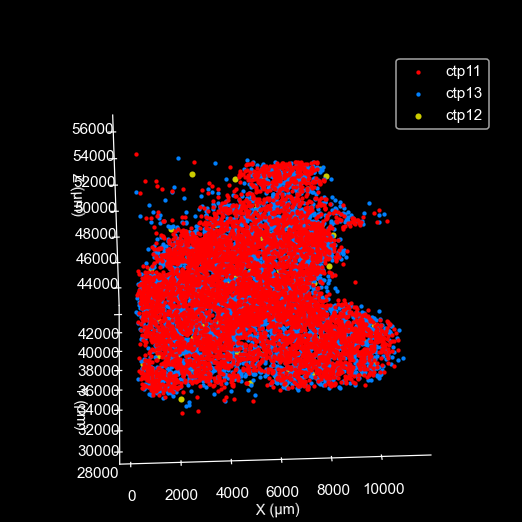

In [29]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[0.8,0.8,0,1], 
                   s=marker_size*2, depthshade=depthshade, 
                   alpha=1,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()

# Pick Spots

In [104]:
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id'])[5:]:
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        break
    break

- Preparing decoding args for fov: 0


In [430]:
from ImageAnalysis3.classes.decode import init_homolog_centers_BB
default_weights = [5,2,1]
default_score_th=-10.
default_metric_names = ['int. mean', 'local dist mean', 'homolog dist']
default_coords_columns = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']

[5, 2, 1]


In [494]:
_picker.chr_2

In [585]:
print(_decoder_filename)

\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-6.hdf5


In [618]:
from ImageAnalysis3.classes import picker
reload(ia.classes.picker)
from ImageAnalysis3.classes.picker import SpotPicker

In [619]:
%%time
_picker = SpotPicker(_decoder_filename, save_file=_decoder_filename.replace('Decoded','Picked'),)
_picker._iterative_assignment(max_niter=1)
_picker._save_picked(detailed_verbose=True)

- Load picker from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked_fov-0_cell-6.hdf5
-- loading merged_codebook
-- loading merged_coords
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 0 in 4.381s. 
Wall time: 4.5 s


In [620]:
def batch_pick_spots(_decoder_filename, num_expected_lib=3, max_niter=10):
    with h5py.File(_decoder_filename, 'r') as _f:
        print(list(_f.keys()))

In [623]:
batch_pick_spots(_decoder_filename)

- Load picker from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked_fov-0_cell-6.hdf5
-- loading merged_codebook
-- loading merged_coords
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 0 in 4.234s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 1 in 3.188s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 2 in 2.478s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 3 in 1.973s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 4 in 1.653s. 
- Save picked coordiantes into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked_fov-0_cell-6.hdf5


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['name', 'id', 'chr'], dtype='object')]

  pytables.to_hdf(


In [626]:
picked_folder = os.path.join(decoder_folder, "Picked")
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)

In [631]:
_pick_args = []
_overwrite_pick = False

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing picking args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id'])[1:]:
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        _picked_filename = os.path.join(picked_folder, f"Picked_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        if not os.path.exists(_picked_filename):
            _pick_args.append(
                (_decoder_filename, _picked_filename, 3, 10, _overwrite_pick)
            )
print(len(_pick_args))

- Preparing picking args for fov: 0
- Preparing picking args for fov: 1
- Preparing picking args for fov: 2
- Preparing picking args for fov: 3
- Preparing picking args for fov: 4
- Preparing picking args for fov: 5
- Preparing picking args for fov: 6
- Preparing picking args for fov: 7
- Preparing picking args for fov: 8
- Preparing picking args for fov: 9
- Preparing picking args for fov: 10
- Preparing picking args for fov: 11
- Preparing picking args for fov: 12
- Preparing picking args for fov: 13
- Preparing picking args for fov: 14
- Preparing picking args for fov: 15
- Preparing picking args for fov: 16
- Preparing picking args for fov: 17
- Preparing picking args for fov: 18
- Preparing picking args for fov: 19
- Preparing picking args for fov: 20
- Preparing picking args for fov: 21
- Preparing picking args for fov: 22
- Preparing picking args for fov: 23
- Preparing picking args for fov: 24
- Preparing picking args for fov: 25
- Preparing picking args for fov: 26
- Preparing

In [629]:
reload(ia.classes.picker)

<module 'ImageAnalysis3.classes.picker' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\picker.py'>

In [632]:
%%time
print(len(_pick_args))
with mp.Pool(32) as pick_pool:
    pick_pool.starmap(ia.classes.picker.batch_pick_spots, _pick_args, chunksize=1)
    pick_pool.close()
    pick_pool.join()
    pick_pool.terminate()

23304


FileExistsError: [Errno 17] Unable to create file (unable to open file: name = '\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked\Picked_fov-7_cell-55.hdf5', errno = 17, error message = 'File exists', flags = 15, o_flags = 502)

In [594]:
_picker.chr_2_scores 

{'1': array([[ -1.5694889 ,  -1.82808299,  -7.84818145,  -5.23064609,
          -5.41818284,  -5.24401035,  -1.34573285,  -7.34679078,
          -4.65362035,  -4.63013296,  -7.8608189 ,  -2.99156539,
          -0.46978756,  -1.18181145,  -4.50796209,  -5.80747446,
          -5.31041797,  -5.90501703,  -1.79461577,  -2.77349103,
          -4.09900654,  -4.99110753,  -3.73844562,  -2.45955806,
          -3.9571375 ,  -3.91607061,  -3.76603748,  -7.40592602,
          -2.22003738,  -8.48264767,  -4.68258479,  -3.6798819 ,
          -5.09258112,  -1.66993321,  -3.62124718,  -4.21572406,
          -4.46891877,  -1.88628998,  -6.14212531,  -6.66148179,
          -2.623824  ,  -8.17267566,  -1.80525611,  -2.36962358,
          -5.85330433, -12.02923086,  -4.33216245,  -2.75519148,
         -11.50248599,  -6.29454006,  -6.13629493,  -6.10925303,
          -3.58902275,  -5.41313385,  -5.4734362 ,  -2.0477098 ,
          -0.92401849,  -1.60010988,  -4.84369686,  -5.68567765,
          -6.0561083

In [588]:
_picker._save_picked(detailed_verbose=True)

- Save picked coordiantes into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked_fov-0_cell-6.hdf5
- Update picked/chr_2_homolog_hzxys_list into \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Picked_fov-0_cell-6.hdf5
-- saving 1 in picked/chr_2_homolog_hzxys_list
-- saving 10 in picked/chr_2_homolog_hzxys_list
-- saving 11 in picked/chr_2_homolog_hzxys_list
-- saving 12 in picked/chr_2_homolog_hzxys_list
-- saving 13 in picked/chr_2_homolog_hzxys_list
-- saving 14 in picked/chr_2_homolog_hzxys_list
-- saving 15 in picked/chr_2_homolog_hzxys_list
-- saving 16 in picked/chr_2_homolog_hzxys_list
-- saving 17 in picked/chr_2_homolog_hzxys_list
-- saving 18 in picked/chr_2_homolog_hzxys_list
-- saving 19 in picked/chr_2_homolog_hzxys_list
-- saving 2 in picked/chr_2_homolog_hzxys_list
-- saving 3 in picked/chr_2_homolog_hzxys_list
-- saving 4 in picked/chr_2_homolog_hzxys_list
-- saving 5 in picked/chr_2_homolog_hzxys_list
-- savin

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['name', 'id', 'chr'], dtype='object')]

  pytables.to_hdf(


In [526]:
np.mean(_picker.history_chr_2_homolog_inds[-1]['1'] != _picker.chr_2_homolog_inds_list['1'])

0.032679738562091505

In [531]:
_determine_selection_changes(_picker)

AttributeError: 'SpotPicker' object has no attribute 'chr_2_change'

In [231]:
_chr_name = '1'
_chr_coords_df = _picker.merged_coords.loc[_picker.merged_coords['chr']==str(_chr_name)]

# get coordinates
_chr_hzxys = _chr_coords_df[['center_intensity']+[f"center_{_x}" for _x in Axis3D_infos]].values
_chr_inds = _chr_coords_df['chr_order'].values

In [358]:
from scipy.spatial.distance import cdist,pdist, squareform

In [269]:
# collect all 

{'1': array([ 23,  77, 142,  25,  88, 108,  14, 106,  98, 102,  77,  30,  71,
         25, 108, 100,  81, 135, 104, 109,  80,  67, 118, 104,  25, 104,
         43,  43,   5, 145,  32,  47,  43,  10,  80, 125,  89,  10, 119,
         77,  25,  32, 145,  32, 100,   8, 130, 137, 145,   6, 141, 111,
          8,  23,  23, 134,  80,  67, 120, 125,   1,   0,  35,  56, 109,
        118,  84,  28,  67,  28,  28,  75, 125, 125, 111,  50,  18,  64,
         96,  30, 137, 102, 135,  61, 128, 137, 109,  17,  57,  56,  77,
         92, 134, 139,  73,   1, 125,  98, 114,  57,   1,  87,  33,  53,
         84,  87,  43,  71,  14,  81, 141,  57, 134,  28, 104, 104,  43,
        139,  89,  57,  47,  64,  23, 101,  20, 137,  17,  98, 120,  19,
         43, 150, 116, 118,  14,  43,  88,  98,  19,  10, 134, 102,  85,
         19,  43,  71,  90,  77, 142, 116,  43, 116, 141,  52, 120,  56,
        119,  85, 141,  57, 104, 101, 104,  85, 137,  83,  32, 142,  43,
         43, 118, 130,  47,  67, 135, 103,  75

(451,)

1
case2 0 1 (1,)
case1 1 5 (1, 0)
case1 3 2 (1, 0)
case2 4 1 (0,)
case1 5 2 (0, 1)
case1 6 2 (1, 0)
case1 8 2 (1, 0)
case1 9 4 (1, 0)
case1 10 3 (1, 0)
case1 11 7 (0, 1)
case1 12 5 (3, 1)
case1 14 3 (0, 1)
case2 15 1 (1,)
case2 16 1 (1,)
case1 17 3 (0, 1)
case2 18 1 (1,)
case1 19 4 (1, 0)
case2 20 1 (0,)
case1 21 2 (1, 0)
case1 22 4 (2, 0)
case1 23 4 (0, 3)
case1 24 3 (0, 2)
case1 25 6 (1, 0)
case1 26 3 (1, 0)
case2 27 1 (0,)
case1 28 5 (0, 3)
case1 29 6 (2, 0)
case1 30 4 (1, 0)
case1 31 2 (0, 1)
case1 32 6 (2, 1)
case1 33 2 (0, 1)
case1 34 6 (1, 0)
case2 35 1 (0,)
case1 36 2 (1, 0)
case1 37 6 (2, 0)
case2 38 1 (0,)
case1 39 3 (2, 1)
case1 40 3 (2, 0)
case1 41 2 (0, 1)
case2 42 1 (0,)
case1 43 11 (3, 2)
case1 44 2 (1, 0)
case1 45 3 (2, 0)
case1 46 5 (0, 1)
case1 47 4 (1, 0)
case1 48 3 (1, 0)
case1 49 2 (0, 1)
case2 50 1 (1,)
case1 51 4 (0, 1)
case1 52 3 (2, 0)
case2 53 1 (0,)
case1 54 5 (0, 1)
case1 56 3 (0, 1)
case1 57 5 (1, 2)
case2 58 1 (1,)
case1 60 5 (1, 0)
case2 61 1 (1,)
case1 6

case1 93 19 (5, 9)
14
case1 0 4 (0, 1)
case1 1 3 (0, 2)
case1 2 2 (1, 0)
case1 3 7 (3, 0)
case1 4 2 (1, 0)
case1 5 3 (2, 0)
case1 6 3 (1, 0)
case1 7 3 (0, 1)
case1 9 2 (0, 1)
case2 10 1 (1,)
case1 11 6 (4, 0)
case1 12 2 (0, 1)
case1 13 6 (4, 0)
case1 14 6 (4, 1)
case1 15 6 (1, 0)
case1 16 7 (1, 0)
case1 17 6 (0, 2)
case1 18 7 (5, 0)
case1 19 3 (0, 1)
case1 20 5 (1, 0)
case1 21 6 (0, 1)
case1 22 6 (2, 0)
case1 23 2 (1, 0)
case1 24 2 (1, 0)
case1 26 3 (0, 1)
case1 27 2 (1, 0)
case2 28 1 (1,)
case1 29 5 (4, 0)
case1 30 6 (4, 0)
case2 31 1 (0,)
case2 32 1 (1,)
case1 33 4 (0, 1)
case1 34 3 (1, 0)
case1 35 6 (1, 0)
case1 36 5 (4, 1)
case1 37 2 (1, 0)
case1 38 2 (1, 0)
case1 39 2 (0, 1)
case2 40 1 (1,)
case1 41 4 (3, 0)
case1 42 8 (1, 7)
case1 43 4 (2, 1)
case1 44 4 (0, 1)
case1 45 2 (1, 0)
case1 47 2 (0, 1)
case1 48 5 (2, 3)
case1 49 2 (1, 0)
case1 50 6 (1, 0)
case1 51 6 (1, 0)
case1 52 6 (3, 0)
case1 53 3 (0, 1)
case1 54 3 (1, 0)
case2 55 1 (0,)
case1 56 7 (0, 1)
case1 57 4 (3, 1)
case1 58 

case1 67 6 (2, 5)
case1 68 2 (0, 1)
case2 70 1 (1,)
case1 71 7 (4, 0)
case1 72 3 (0, 1)
case1 73 4 (0, 3)
case2 75 1 (0,)
case2 76 1 (1,)
case1 77 8 (0, 1)
case1 78 7 (2, 0)
case2 79 1 (1,)
case1 80 6 (1, 2)
case1 81 2 (1, 0)
case1 82 2 (0, 1)
case1 83 4 (0, 1)
case1 84 7 (2, 0)
case1 85 7 (1, 2)
case1 86 3 (0, 1)
case1 87 6 (2, 0)
case1 88 9 (2, 0)
case1 89 3 (0, 1)
case1 90 5 (2, 0)
case2 91 1 (1,)
case1 92 5 (0, 2)
case2 93 1 (1,)
case1 94 2 (1, 0)
case1 95 9 (2, 3)
case1 96 5 (0, 1)
case1 97 3 (2, 1)
case1 98 7 (0, 1)
case1 99 4 (0, 1)
case1 100 4 (2, 0)
case1 101 9 (2, 1)
case1 102 7 (0, 1)
case1 103 5 (0, 1)
case2 104 1 (0,)
case1 105 7 (6, 0)
case1 106 5 (0, 1)
case1 107 8 (3, 1)
case1 108 5 (1, 0)
case1 109 3 (0, 1)
case1 110 2 (0, 1)
case1 111 4 (0, 1)
case1 112 6 (1, 0)
case1 113 9 (1, 0)
case1 114 6 (2, 0)
case1 115 4 (2, 0)
case1 116 2 (0, 1)
case1 117 4 (0, 1)
case1 118 4 (0, 1)
case2 119 1 (0,)
case1 120 8 (2, 3)
case1 121 5 (1, 0)
case1 122 6 (2, 0)
case1 124 3 (1, 2)
ca

case1 72 3 (0, 2)
case1 73 4 (0, 3)
case1 74 2 (0, 1)
case1 75 4 (1, 0)
case1 76 5 (3, 0)
case2 77 1 (1,)
case2 78 1 (1,)
case1 79 5 (1, 0)
case1 80 7 (1, 0)
case1 81 6 (1, 0)
case1 82 5 (0, 2)
case1 83 5 (0, 1)
case1 84 6 (2, 0)
case1 85 5 (1, 2)
case1 86 5 (1, 0)
case1 87 4 (1, 0)
case1 88 3 (0, 1)
case1 89 3 (0, 1)
case1 90 4 (2, 0)
case1 91 2 (0, 1)
case1 92 2 (1, 0)
case1 93 2 (1, 0)
case1 94 2 (0, 1)
case1 95 4 (1, 0)
case1 96 4 (0, 3)
case1 97 4 (1, 0)
case1 98 2 (0, 1)
case2 99 1 (1,)
case1 100 3 (0, 2)
case1 101 7 (0, 5)
case1 102 5 (1, 0)
case1 103 7 (1, 3)
case1 104 8 (0, 2)
case1 105 5 (1, 0)
case1 106 4 (0, 1)
case1 107 3 (0, 1)
case1 108 4 (2, 0)
case1 109 4 (1, 0)
case1 110 3 (0, 1)
case1 111 5 (0, 2)
case1 112 7 (3, 4)
case1 113 3 (0, 1)
7
case1 0 6 (5, 4)
case1 1 3 (0, 1)
case1 2 12 (3, 0)
case1 3 4 (0, 1)
case1 4 8 (1, 0)
case1 5 11 (2, 6)
case1 6 6 (1, 3)
case1 7 9 (0, 1)
case1 8 9 (0, 2)
case1 9 9 (2, 0)
case1 10 6 (1, 0)
case1 11 6 (0, 1)
case1 12 4 (2, 1)
case1 13

In [391]:
_picker.merged_coords.iloc[1529]

region_name         1:6240000-6260000
chr                                 1
start                         6240000
end                           6260000
center_intensity          1438.517257
center_z                  7166.750833
center_x                 13246.672824
center_y                   189437.328
codebook_name                   CTP11
data_type                       combo
index                               1
chr_order                           1
Name: 1529, dtype: object

<IPython.core.display.Javascript object>


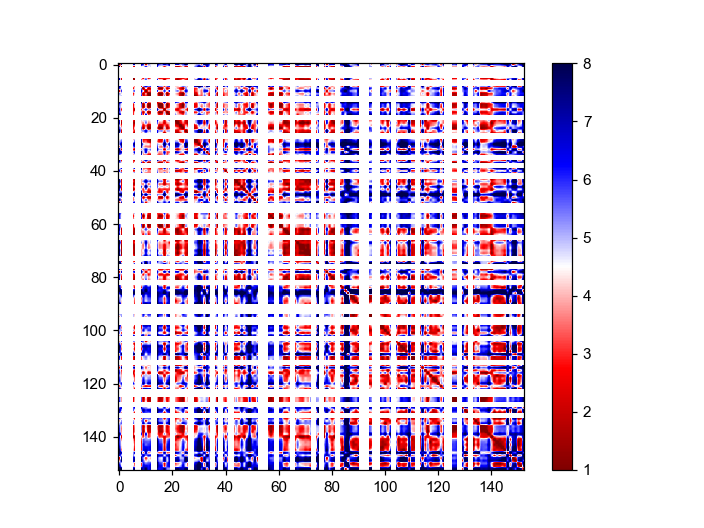

In [402]:
plt.figure()
plt.imshow(squareform(pdist(homolog_hzxys_list[1]))/1000, cmap='seismic_r', vmin=1, vmax=8)
plt.colorbar()
plt.show()

In [303]:
from scipy.stats import percentileofscore
def cdf_scores(values, refs, greater=True):
    
    if np.isnan(refs).all():
        return np.nan * np.ones(np.shape(values))
    if greater:
        return np.array([percentileofscore(refs, _v, kind='weak')/100 + 0.5/len(refs) 
                         for _v in values])
    else:
        return np.array([1 - percentileofscore(refs, _v, kind='weak')/100 + 0.5/len(refs) 
                         for _v in values])

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,

In [307]:
_all_metrics[0][np.isreal(_all_metrics[0])]

array([3372.5422    , 4202.14023333, 5052.06466667, ..., 1747.06588667,
       1318.6343    , 1222.8866    ])

In [309]:
_metrics[0].shape

(2, 451)

array([[0.91465442, 0.96287594, 0.98478167, 0.97169607, 0.7174306 ,
        0.96938259, 0.86072152, 0.91776316, 0.92947513, 0.96070706,
        0.66776316, 0.87749422, 0.93048728, 0.81907895, 0.91226865,
        0.75010844, 0.75791643, 0.77266484, 0.83700839, 0.71974407,
        0.89918305, 0.7751952 , 0.97039474, 0.97516628, 0.78603962,
        0.7713635 , 0.7695561 , 0.75589213, 0.98138375, 0.80418595,
        0.60052776, 0.82717611, 0.84373193, 0.91602805, 0.82674234,
        0.68648785, 0.92643869, 0.69407895, 0.95138086, 0.43468045,
        0.76037449, 0.71236987, 0.88971226, 0.77035136, 0.61708357,
        0.38392857, 0.99034847, 0.79536582, 0.42918595, 0.69791064,
        0.59734673, 0.58339358, 0.53994361, 0.7061524 , 0.46106854,
        0.76304945, 0.83173077, 0.92455899, 0.64318248, 0.51066368,
        0.84141845, 0.59749132, 0.26095286, 0.70210382, 0.52881001,
        0.36426403, 0.31676547, 0.59308126, 0.70340515, 0.62908473,
        0.5923583 , 0.61252892, 0.42007663, 0.32

In [325]:
chr_2_scores['1'].shape

(2, 451)

In [ ]:
chr_2_scores['1'].shape

In [321]:
np.array(_scores).sum(0).shape

(1, 4)

<IPython.core.display.Javascript object>


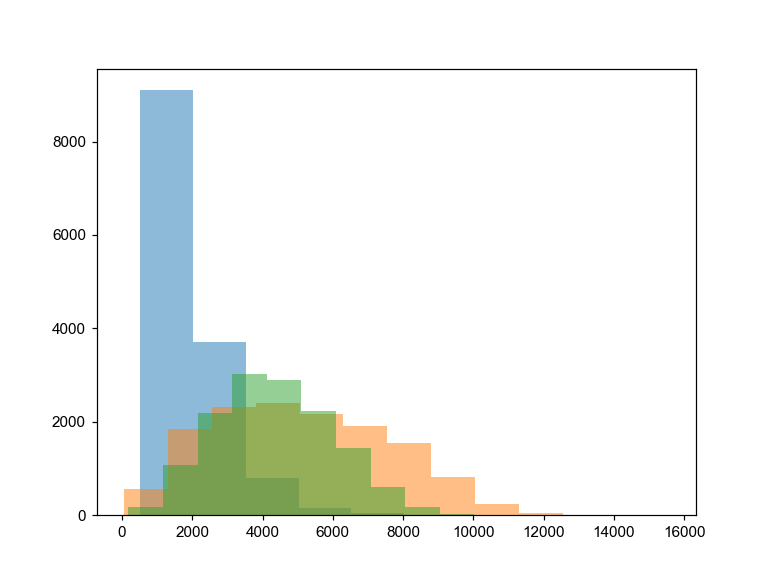

(array([ 181., 1073., 2185., 3019., 2888., 2225., 1444.,  615.,  182.,
          20.]),
 array([  183.10380921,  1167.774766  ,  2152.44572278,  3137.11667957,
         4121.78763636,  5106.45859314,  6091.12954993,  7075.80050672,
         8060.4714635 ,  9045.14242029, 10029.81337707]),
 <BarContainer object of 10 artists>)

In [299]:
plt.figure()
plt.hist(_all_metrics[0], alpha=0.5)
plt.hist(_all_metrics[1], alpha=0.5)
plt.hist(_all_metrics[2], alpha=0.5)

In [228]:
_chr_zxys

array([[  3618.78908333,  14039.45532   , 188862.912     ],
       [  1779.80586667,  12260.069856  , 184501.2312    ],
       [  1347.24441667,   8534.1006    , 179852.7456    ],
       ...,
       [  4224.23475   ,  11271.57714   , 182858.7582    ],
       [  1046.2479625 ,  13978.72296   , 182394.6336    ],
       [  8210.95625   ,  13844.2959    , 190483.272     ]])

In [230]:
_picker.merged_coords

,region_name,chr,start,end,center_intensity,center_z,center_x,center_y,codebook_name,data_type,index,chr_order
0,2:141240000-141260000,2,141240000,141260000,5122.939433,1532.050208,12339.40428,186063.8832,CTP11,combo,132,112
1,13:28740000-28760000,13,28740000,28760000,3619.137033,3117.200292,11969.21790,180840.1284,CTP11,combo,682,19
2,9:101240000-101260000,9,101240000,101260000,6906.795233,2576.030333,15659.96940,184399.5276,CTP11,combo,520,79
3,6:18740000-18760000,6,18740000,18760000,3798.931367,7248.819583,12485.50488,185633.5392,CTP11,combo,331,12
4,13:8740000-8760000,13,8740000,8760000,5477.193600,2562.590083,16807.31964,183717.9756,CTP11,combo,674,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6993,2:21622583-21703613,2,21622583,21703613,1635.907700,3679.294375,10346.91948,187244.1522,CTP13,combo,1101,17
6994,8:41328066-41394762,8,41328066,41394762,521.812485,7975.865250,14666.50422,182354.7114,CTP13,combo,1456,29
6995,13:64427959-64496783,13,64427959,64496783,583.598250,8094.602000,13601.26998,182645.4798,CTP13,combo,1730,50
6996,12:86672397-86725863,12,86672397,86725863,560.181350,7280.277500,14266.11852,186935.0670,CTP13,combo,1694,57


In [192]:
_picker.chr_2_homolog_centers['1']

array([[  1717.79079167,  17360.04636   , 185049.5292    ],
       [  5067.05733333,  12699.16254   , 186727.1688    ]])

<IPython.core.display.Javascript object>


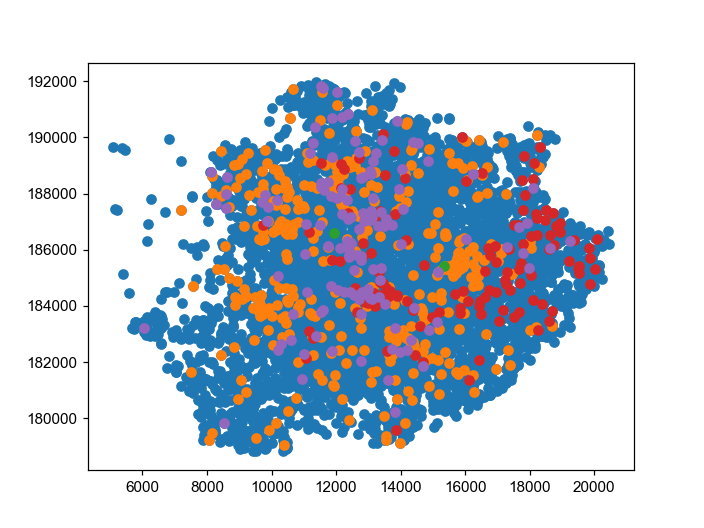

In [410]:
plt.figure()
_chr = '1'
_chr_coords = _picker.merged_coords.loc[_picker.merged_coords['chr']=='11']
plt.scatter(_picker.merged_coords['center_x'],_picker.merged_coords['center_y'])
plt.scatter(_chr_coords['center_x'],_chr_coords['center_y'])
plt.scatter(_picker.chr_2_homologCenters[_chr][:,1], _picker.chr_2_homologCenters[_chr][:,2] )
plt.scatter(homolog_hzxys_list[1][:,2], homolog_hzxys_list[1][:,3] )
plt.scatter(homolog_hzxys_list[0][:,2], homolog_hzxys_list[0][:,3] )


In [159]:
_picker.merged_coords.loc[_picker.merged_coords['index']==7]

,region_name,chr,start,end,center_intensity,center_z,center_x,center_y,codebook_name,data_type,index,chr_order
506,1:21240000-21260000,1,21240000,21260000,3384.3690,2625.793208,13530.625524,188646.6564,CTP11,combo,7,10
569,1:21240000-21260000,1,21240000,21260000,2116.6316,5206.889583,13070.988360,187048.8972,CTP11,combo,7,10
2152,1:21240000-21260000,1,21240000,21260000,1476.4111,8283.203625,8982.463680,188071.5942,CTP11,combo,7,10


In [147]:
_merged_coords

,region_name,chr,start,end,center_intensity,center_z,center_x,center_y,codebook_name,data_type,index,chr_order
0,2:141240000-141260000,2,141240000,141260000,5122.939433,1532.050208,12339.40428,186063.8832,CTP11,combo,132,112
1,13:28740000-28760000,13,28740000,28760000,3619.137033,3117.200292,11969.21790,180840.1284,CTP11,combo,682,19
2,9:101240000-101260000,9,101240000,101260000,6906.795233,2576.030333,15659.96940,184399.5276,CTP11,combo,520,79
3,6:18740000-18760000,6,18740000,18760000,3798.931367,7248.819583,12485.50488,185633.5392,CTP11,combo,331,12
4,13:8740000-8760000,13,8740000,8760000,5477.193600,2562.590083,16807.31964,183717.9756,CTP11,combo,674,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6993,2:21622583-21703613,2,21622583,21703613,1635.907700,3679.294375,10346.91948,187244.1522,CTP13,combo,1101,17
6994,8:41328066-41394762,8,41328066,41394762,521.812485,7975.865250,14666.50422,182354.7114,CTP13,combo,1456,29
6995,13:64427959-64496783,13,64427959,64496783,583.598250,8094.602000,13601.26998,182645.4798,CTP13,combo,1730,50
6996,12:86672397-86725863,12,86672397,86725863,560.181350,7280.277500,14266.11852,186935.0670,CTP13,combo,1694,57


In [125]:
_chr_orders

[112]

In [111]:
_merged_coords['index'] = []

,region_name,chr,start,end,center_intensity,center_z,center_x,center_y,codebook_name,data_type
0,2:141240000-141260000,2,141240000,141260000,5122.939433,1532.050208,12339.40428,186063.8832,CTP11,combo
1,13:28740000-28760000,13,28740000,28760000,3619.137033,3117.200292,11969.21790,180840.1284,CTP11,combo
2,9:101240000-101260000,9,101240000,101260000,6906.795233,2576.030333,15659.96940,184399.5276,CTP11,combo
3,6:18740000-18760000,6,18740000,18760000,3798.931367,7248.819583,12485.50488,185633.5392,CTP11,combo
4,13:8740000-8760000,13,8740000,8760000,5477.193600,2562.590083,16807.31964,183717.9756,CTP11,combo
...,...,...,...,...,...,...,...,...,...,...
6993,2:21622583-21703613,2,21622583,21703613,1635.907700,3679.294375,10346.91948,187244.1522,CTP13,combo
6994,8:41328066-41394762,8,41328066,41394762,521.812485,7975.865250,14666.50422,182354.7114,CTP13,combo
6995,13:64427959-64496783,13,64427959,64496783,583.598250,8094.602000,13601.26998,182645.4798,CTP13,combo
6996,12:86672397-86725863,12,86672397,86725863,560.181350,7280.277500,14266.11852,186935.0670,CTP13,combo


In [90]:
codebook_df.loc[codebook_df['chr']=='2',['chr_order']].values.shape

(148, 1)

In [95]:
_picker.merged_codebook

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,X:101910335-102015609,987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1980,X:136772307-136851006,988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,X:140481839-140547985,989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982,X:167122110-167191320,990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
